In [2]:
!gdown 1-GsIZrtsWtzQMuLo81Nm6kJbcKqjaX4w
!unzip -q /content/google_stock.zip

Downloading...
From: https://drive.google.com/uc?id=1-GsIZrtsWtzQMuLo81Nm6kJbcKqjaX4w
To: /content/google_stock.zip
100% 96.9k/96.9k [00:00<00:00, 68.6MB/s]


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import seasonal_decompose

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

plt.style.use('fivethirtyeight')

data = pd.read_csv("/content/googl_daily_prices.csv")
data.head(10)

cpu


,date,1. open,2. high,3. low,4. close,5. volume
0,2025-05-28,173.160,175.265,171.9107,172.36,34284926.0
1,2025-05-27,170.160,173.170,170.0000,172.90,37995670.0
2,2025-05-23,169.055,169.960,167.8900,168.47,35211439.0
3,2025-05-22,171.850,176.770,170.7100,170.87,74864418.0
4,2025-05-21,163.690,173.140,163.5600,168.56,73415956.0
5,2025-05-20,166.430,168.500,162.9000,163.98,46607656.0
6,2025-05-19,164.510,166.640,164.2200,166.54,30426097.0
7,2025-05-16,167.725,169.350,165.6200,166.19,42846925.0
8,2025-05-15,165.840,166.205,162.3732,163.96,33146669.0
9,2025-05-14,159.960,167.000,159.6100,165.37,48755869.0


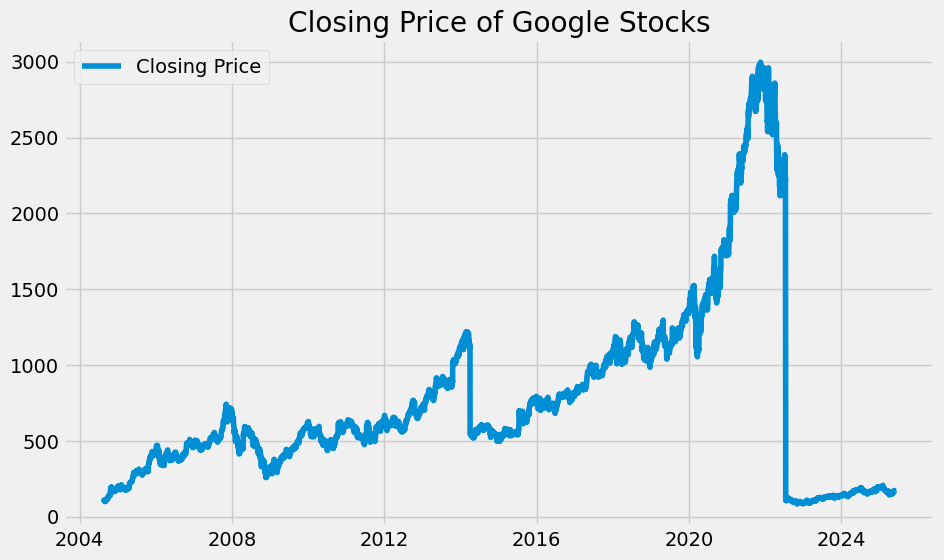

In [9]:
data['close'] = data['4. close']
data.drop(['4. close'],inplace=True,axis=1)
data = data[['close','date']]

df = data.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

plt.figure(figsize=(10,6))
plt.plot(df['close'],label="Closing Price")
plt.legend()
plt.title("Closing Price of Google Stocks")
plt.show()

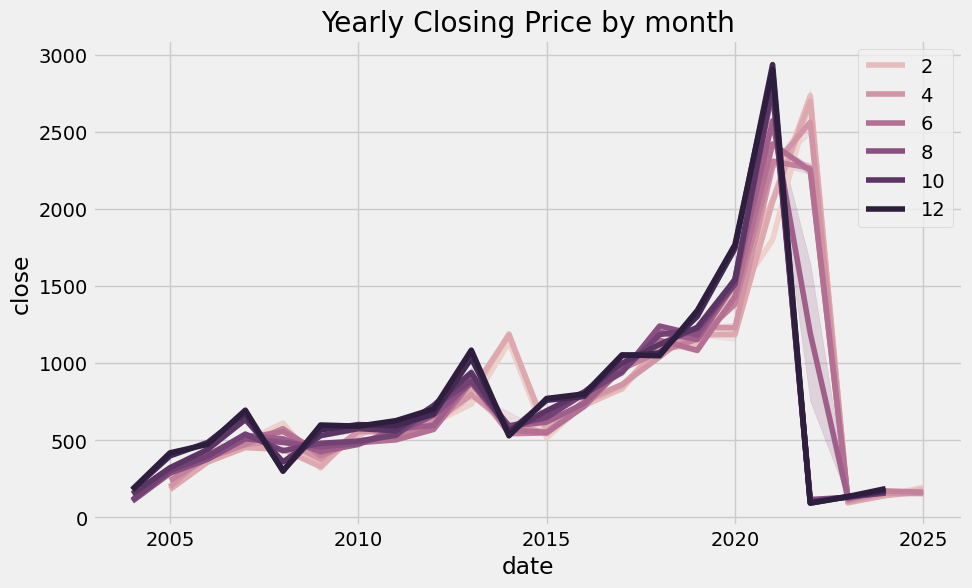

In [10]:
df1 = df.copy()

plt.figure(figsize=(10,6))
sns.lineplot(x=df1.index.year,y=df1.close,hue=df1.index.month)
plt.title("Yearly Closing Price by month")
plt.legend()
plt.show()

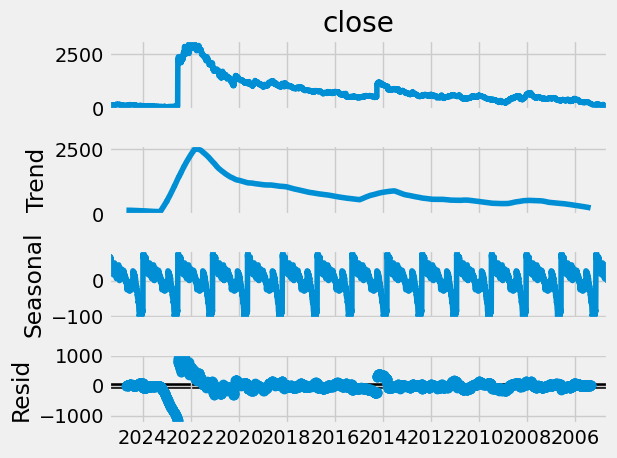

In [11]:
decomp = seasonal_decompose(df.close,model="additive",period=365)
decomp.plot().show()

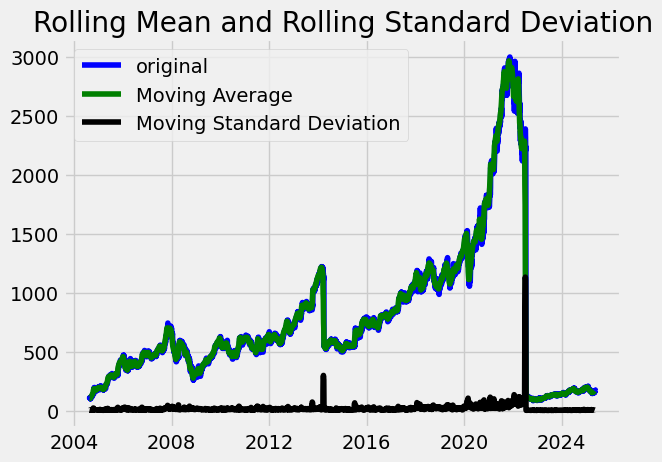

Results from Dickey Fueller

Test Statistic                   -2.068178
p-value                           0.257501
'#Lags Used                      24.000000
Number of Observations Used    5202.000000
Critical Value (1%)              -3.431608
Critical Value (5%)              -2.862096
Critical Value (10%)             -2.567066
dtype: float64


In [12]:
def test_stationary(timeseries):

    movingaverage = timeseries.rolling(window=12).mean()
    movingstd = timeseries.rolling(window=12).std()
    plt.plot(timeseries,color="blue",label="original")
    plt.plot(movingaverage,color="green",label="Moving Average")
    plt.plot(movingstd,color="black",label="Moving Standard Deviation")
    plt.title("TimeSeries For Google Closing Prices")
    plt.legend(loc="best")
    plt.title("Rolling Mean and Rolling Standard Deviation")
    plt.show(block=False)

    print('Results from Dickey Fueller\n')
    df_test = adfuller(timeseries['close'],autolag="AIC")
    dfoutput = pd.Series(df_test[0:4],index=['Test Statistic','p-value',"'#Lags Used","Number of Observations Used"])
    for key,value in df_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


test_stationary(df)

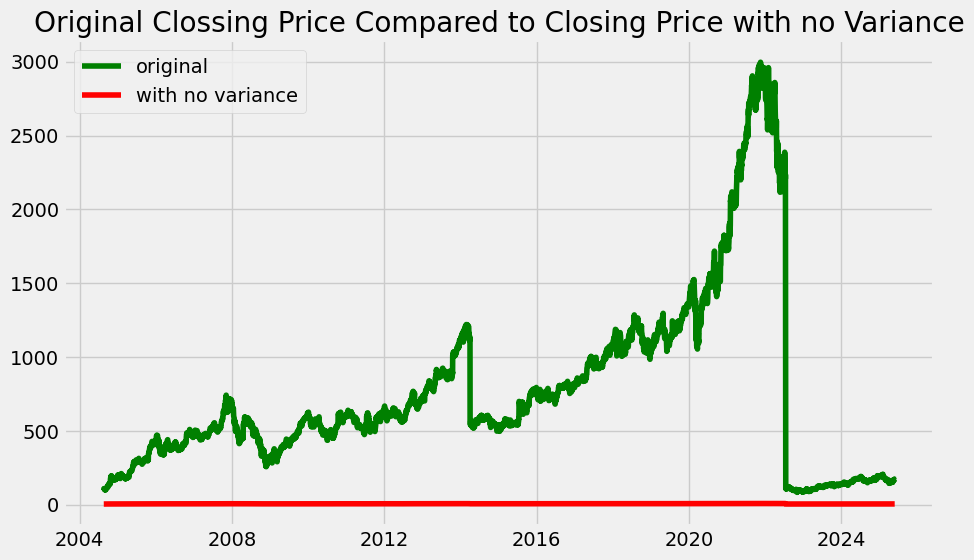

In [13]:
"""With no Variance"""

df_log = np.log(df)

plt.figure(figsize=(10,6))
plt.plot(df,color='green',label="original")
plt.plot(df_log,color='red',label="with no variance")
plt.title("Original Clossing Price Compared to Closing Price with no Variance")
plt.legend()
plt.show()

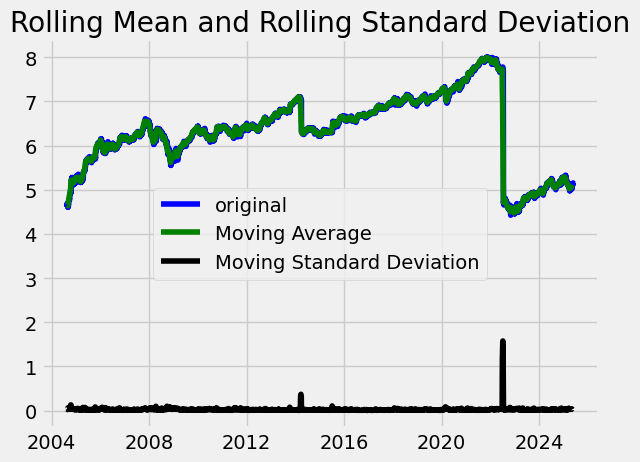

Results from Dickey Fueller

Test Statistic                   -1.803425
p-value                           0.378763
'#Lags Used                       0.000000
Number of Observations Used    5226.000000
Critical Value (1%)              -3.431602
Critical Value (5%)              -2.862093
Critical Value (10%)             -2.567064
dtype: float64


In [14]:
df_log.dropna(inplace=True)
test_stationary(df_log)

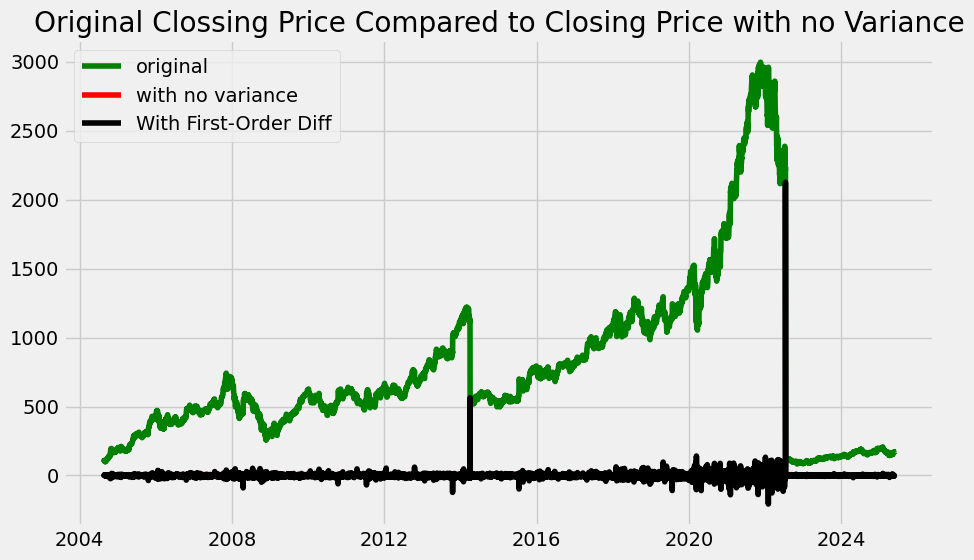

In [15]:
df_diff = df.diff(periods=1)

plt.figure(figsize=(10,6))
plt.plot(df,color='green',label="original")
plt.plot(df_log,color='red',label="with no variance")
plt.plot(df_diff,color='black',label="With First-Order Diff")
plt.title("Original Clossing Price Compared to Closing Price with no Variance")
plt.legend()
plt.show()

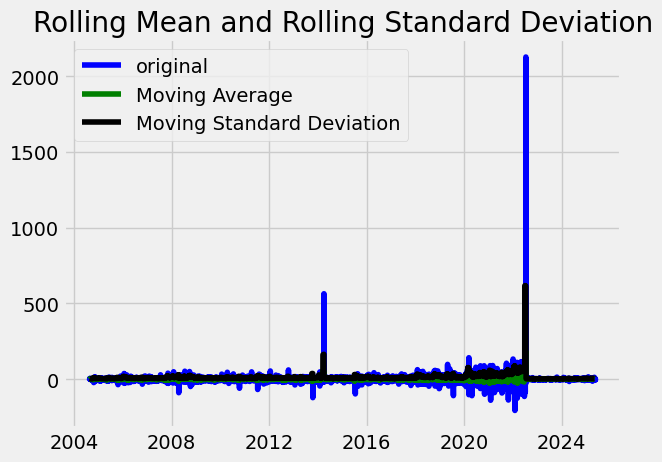

Results from Dickey Fueller

Test Statistic                -1.437752e+01
p-value                        9.270872e-27
'#Lags Used                    2.300000e+01
Number of Observations Used    5.202000e+03
Critical Value (1%)           -3.431608e+00
Critical Value (5%)           -2.862096e+00
Critical Value (10%)          -2.567066e+00
dtype: float64


In [16]:
df_diff.dropna(inplace=True)

test_stationary(df_diff)

In [17]:
data['lag1'] = data['close'].shift(periods=1)
data.dropna(inplace=True)
data = data[['lag1','date']]

In [18]:
data.drop_duplicates(inplace=True)

training = data.iloc[:,0:1].values
training

array([[172.36],
       [172.9 ],
       [168.47],
       ...,
       [104.87],
       [109.4 ],
       [108.31]])

In [20]:
train_size = int(len(data)*.90)

train_data = training[:train_size]
test_data = training[train_size:]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

def slider(dataset,seq_length):
    X,y = [],[]
    for i in range(len(dataset) - seq_length):
        Xi = dataset[i:(seq_length+i)]
        yi = dataset[(i+seq_length)]
        X.append(Xi)
        y.append(yi)
    return np.array(X),np.array(y)

seq_length = 4
X_train,y_train = slider(train_scaled,seq_length)
X_test,y_test = slider(test_scaled,seq_length)

X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([4699, 4, 1])
torch.Size([519, 4, 1])
torch.Size([4699, 1])
torch.Size([519, 1])


In [21]:
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers,output_size):
        super(LSTM,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)

        self.fc = nn.Linear(hidden_size,output_size)

    def forward(self,X):
        h0 = torch.zeros(1,X.size(0),self.hidden_size)
        c0 = torch.zeros(1,X.size(0),self.hidden_size)
        out,_ = self.lstm(X,(h0,c0))
        out = self.fc(out[:,-1,:])
        return out

model = LSTM(input_size=1,hidden_size=512,num_layers=1,output_size=1)
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
loss_fn = nn.MSELoss()
epochs = 200

for epoch in range(epochs):
    y_pred = model(X_train)
    loss = loss_fn(y_pred.float(),y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 1 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rsme = np.sqrt(loss_fn(y_pred,y_train))
        y_pred_test =  model(X_test)
        test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))
        print(f'Epoch: {epoch}; train_RSEM: {train_rsme:.4}; Test RSME: {test_rsme:.4}')

<ipython-input-21-7c7c0a56e0df>:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rsme = np.sqrt(loss_fn(y_pred,y_train))
<ipython-input-21-7c7c0a56e0df>:41: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))


Epoch: 0; train_RSEM: 0.3306; Test RSME: 0.4303
Epoch: 1; train_RSEM: 0.3554; Test RSME: 0.1081
Epoch: 2; train_RSEM: 0.2884; Test RSME: 0.04233
Epoch: 3; train_RSEM: 0.2509; Test RSME: 0.04445
Epoch: 4; train_RSEM: 0.2405; Test RSME: 0.05356
Epoch: 5; train_RSEM: 0.1779; Test RSME: 0.175
Epoch: 6; train_RSEM: 0.2679; Test RSME: 0.3404
Epoch: 7; train_RSEM: 0.4083; Test RSME: 0.2254
Epoch: 8; train_RSEM: 0.226; Test RSME: 0.04051
Epoch: 9; train_RSEM: 0.1744; Test RSME: 0.2274
Epoch: 10; train_RSEM: 0.268; Test RSME: 0.3399
Epoch: 11; train_RSEM: 0.1842; Test RSME: 0.2387
Epoch: 12; train_RSEM: 0.1635; Test RSME: 0.1268
Epoch: 13; train_RSEM: 0.1968; Test RSME: 0.06221
Epoch: 14; train_RSEM: 0.2128; Test RSME: 0.03898
Epoch: 15; train_RSEM: 0.2032; Test RSME: 0.03722
Epoch: 16; train_RSEM: 0.1732; Test RSME: 0.05043
Epoch: 17; train_RSEM: 0.1333; Test RSME: 0.08187
Epoch: 18; train_RSEM: 0.1112; Test RSME: 0.1268
Epoch: 19; train_RSEM: 0.1336; Test RSME: 0.1674
Epoch: 20; train_RSEM: 0

In [22]:
with torch.no_grad():
    pred = model(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)

test_dates = data.iloc[train_size + seq_length:]['date']

comparison_df = pd.DataFrame({
    "date": test_dates,
    "Actual Closing Price": actual_rescaled.flatten(),
    "Predicted Closing Price": pred_rescaled.flatten()
})

print(comparison_df.head(20))

            date  Actual Closing Price  Predicted Closing Price
4708  2006-09-08            384.089996               404.790375
4709  2006-09-07            377.850006               398.178192
4710  2006-09-06            378.489990               392.156036
4711  2006-09-05            380.140015               384.571136
4712  2006-09-01            384.360016               381.422668
4713  2006-08-31            378.600006               381.043793
4714  2006-08-30            378.530029               381.835083
4715  2006-08-29            380.750000               381.596710
4716  2006-08-28            378.949982               381.788025
4717  2006-08-25            380.949982               380.508759
4718  2006-08-24            373.260010               380.828125
4719  2006-08-23            373.729980               380.283264
4720  2006-08-22            373.429993               378.108582
4721  2006-08-21            378.289978               376.959808
4722  2006-08-18            377.299988  

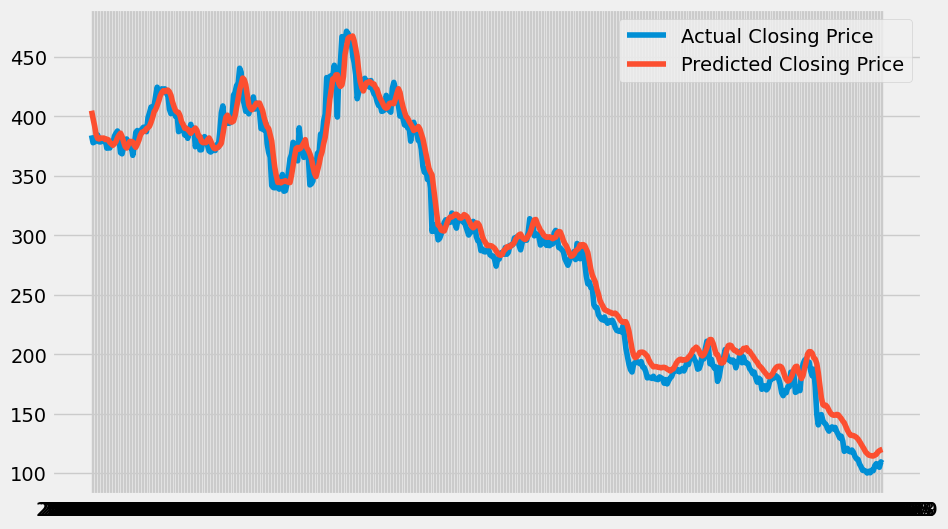

In [23]:
plt.figure(figsize=(10,6))
plt.plot(comparison_df['date'],comparison_df["Actual Closing Price"],label="Actual Closing Price")
plt.plot(comparison_df['date'],comparison_df['Predicted Closing Price'],label="Predicted Closing Price")
plt.legend()
plt.show()